In [2]:
import numpy as np
from math import cos, sin, pi

# From Ryan Keating via mc-capolei
# https://raw.githubusercontent.com/mc-capolei/python-Universal-robot-kinematics/master/universal_robot_kinematics.py

# https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/
# ****** Coefficients ******


# UR 5e

d1 = 0.1625
a2 = -0.425
a3 = -0.3922
d4 = 0.1333
d5 = 0.0997
d6 = 0.0996

d = np.array([d1, 0, 0, d4, d5, d6])
a = np.array([0, a2, a3, 0, 0, 0])
alph = np.array([pi / 2, 0, 0, pi / 2, -pi / 2, 0])

In [3]:
def AH(n, th):

    T_a = np.array(np.identity(4), copy=False)
    T_a[0, 3] = a[n - 1]
    T_d = np.array(np.identity(4), copy=False)
    T_d[2, 3] = d[n - 1]

    Rzt = np.array(
        [
            [cos(th[n - 1]), -sin(th[n - 1]), 0, 0],
            [sin(th[n - 1]), cos(th[n - 1]), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ],
        copy=False,
    )

    Rxa = np.array(
        [
            [1, 0, 0, 0],
            [0, cos(alph[n - 1]), -sin(alph[n - 1]), 0],
            [0, sin(alph[n - 1]), cos(alph[n - 1]), 0],
            [0, 0, 0, 1],
        ],
        copy=False,
    )

    A_i = T_d @ Rzt @ T_a @ Rxa

    return A_i

In [4]:
def HTrans(th):
    A_1 = AH(1, th)
    A_2 = AH(2, th)
    A_3 = AH(3, th)
    A_4 = AH(4, th)
    A_5 = AH(5, th)
    A_6 = AH(6, th)

    T_01 = A_1
    T_02 = T_01 @ A_2
    T_03 = T_02 @ A_3
    T_04 = T_03 @ A_4 
    T_05 = T_04 @ A_5   
    T_06 = T_05 @ A_6
  
    transforms = [T_01, T_02, T_03, T_04, T_05, T_06]

    return transforms

In [5]:
from spatialmath import SE3, Twist3

def get_joint_twists():
    # everything in the space frame aka base frame
    joint_twists = []
    
    # first joint
    axis = np.array([0, 0, 1]) # rotates around z, right hand rule
    point = np.array([0, 0, 0]) # a point on the axis of rotation
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    # second joint
    axis = np.array([0, -1, 0])
    point = np.array([0, 0, d1])
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    # third joint
    axis = np.array([0, -1, 0])
    point = np.array([a2, 0, d1])
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    # fourth joint
    axis = np.array([0, -1, 0])
    point = np.array([a2 + a3, -d4, d1])
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    # fifth joint
    axis = np.array([0, 0, -1])
    point = np.array([a2 + a3, -d4, d1 - d5])
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    # sixth joint
    axis = np.array([0, -1, 0])
    point = np.array([a2 + a3, -d4 - d6, d1 - d5])
    twist = Twist3.UnitRevolute(axis, point)
    joint_twists.append(twist)
    
    return joint_twists

zero_config_fk = HTrans([0]*6)[-1]
zero_config_fk = SE3(zero_config_fk)    

def get_fk_from_twists(joint_angles):
    joint_twists = get_joint_twists()
    relative_transforms = []
    for idx, joint_twist in enumerate(joint_twists):
        angle = joint_angles[idx]
        transform = SE3(joint_twist.exp(angle))
        relative_transforms.append(transform)
        
    fk = zero_config_fk
    for transform in relative_transforms[::-1]:  # apply in reverse order
        fk = transform * fk
    return fk

def get_ur5e_jacobian_from_twists(angles, frame=None):
    if frame is None:
        frame = "body"
    joint_twists = get_joint_twists()
    relative_transforms = []
    for idx, joint_twist in enumerate(joint_twists):
        angle = angles[idx]
        relative_transforms.append(SE3(joint_twist.exp(angle)))
    jacobian = np.zeros([6, 6])
    twist_transform = SE3(np.eye(4))
    for idx in range(6):
        if idx > 0:
            twist_transform = twist_transform @ relative_transforms[idx-1]
        jacobian[:, idx] = twist_transform.Ad() @ joint_twists[idx].A  
    
    if frame == "space":
        return jacobian
    elif frame == "body":
        fk = zero_config_fk
        for transform in relative_transforms[::-1]:  # apply in reverse order
            fk = transform * fk
        return fk.inv().Ad() @ jacobian
    else:
        raise Exception(f"frame: {frame} not in (space, body)")

def get_body_twist_from_transform(desired_transform, current_transform):
    """
    Even though both desired_transform and current_transform are in space frame,
    this returns a twist in the body frame.
    """
    transform_from_desired = SE3(current_transform).inv().A @ desired_transform
    twist = SE3(transform_from_desired).log(twist=True)
    return twist

def get_body_twist(current, desired):
    # swap arguments to match Sam's code
    body_twist = get_body_twist_from_transform(desired, current)
    return body_twist

def get_space_twist(current, desired):
    body_twist = get_body_twist(current, desired)
    space_twist = SE3(current).Ad() @ body_twist
    return space_twist

def space_jacobian(joint_angles):
    return get_ur5e_jacobian_from_twists(joint_angles, frame="space")
    
def body_jacobian(joint_angles):
    return get_ur5e_jacobian_from_twists(joint_angles, frame="body")
    


In [6]:
# https://github.com/PaperXLV/DifferentialInverseKinematics
from Examples import task_one

In [7]:
sam_output = task_one(trials=[35], modes=["DLS"])

In [8]:
space_output = task_one(trials=[35], modes=["DLS"], jacobian_fn=space_jacobian, desired_twist_fn=get_space_twist)

In [9]:
body_output = task_one(trials=[35], modes=["DLS"], jacobian_fn=body_jacobian, desired_twist_fn=get_body_twist)


In [10]:
print(space_output[0][:5])
positions = space_output[0]

[[0.032, -1.3725181970436138, -1.1385929148786316, -1.999047792816215, 1.6238761884484256, 3.1735170462061815], [0.064, -1.363854336088454, -1.1464128658117576, -1.9982519265911864, 1.6176651966933768, 3.2049992349356717], [0.096, -1.3559824342410949, -1.1535066101951006, -1.9975964786518676, 1.611370619751199, 3.2364475373382473], [0.128, -1.348881588808139, -1.1599134180363937, -1.9970682922133878, 1.6049952864934351, 3.2678626542999853], [0.16, -1.3425356537426427, -1.1656655893735408, -1.9966570302411422, 1.5985408749889645, 3.2992448439500754]]


In [16]:

from Webots import *
# running space_output
positions = space_output[0]
# To run the manipulator
i = 0
while robot.step(timestep) != -1:
    position = positions[i]
    [motor.setPosition(angle) for motor, angle in zip(joint_motors, position)]

    i += 1
    if i == len(positions):
        break


: 

: 

In [18]:
from ProjectResults import create_error_plot, create_ellipse_plot, waypoints

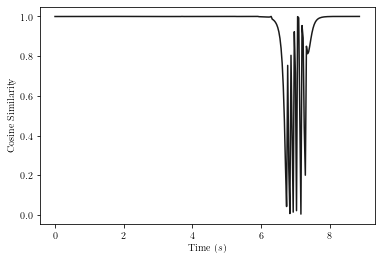

In [15]:
# Cosine similarity plot for space output actual and desired twist
create_error_plot(np.array(space_output[3][0]), np.array(space_output[4][0]))

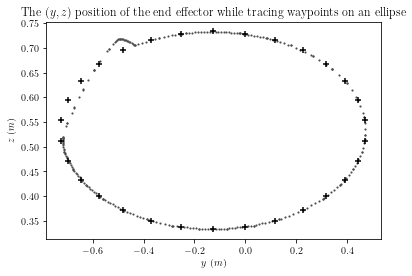

In [19]:
# Ellipse plot for space output positions
create_ellipse_plot(np.array(space_output[2][0]), waypoints)